# Sequence Level Features and Analysis

In [506]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ttest_1samp, poisson
from Bio import pairwise2
from Bio.pairwise2 import format_alignment



pd.set_option('display.float_format', '{:.10e}'.format)
pd.set_option('display.max_colwidth', 30)

In [507]:
csv_file = "../Data/R12-clean.csv"
df = pd.read_csv(csv_file)
df.head(5)

,Sequence,Copy Num,Length
0,AGTGCCATCGTGCGTATCCTTCACTC...,91,98
1,AGTGCCATCGTGCGTATCCTTCACGT...,86,98
2,AGTGCCATCGTGCGTATCCTGAACAT...,83,98
3,AGTGCCATCGTGCGTATCCCGCTCCG...,80,98
4,AGTGCCATCGTGCGTATCCTGAACAT...,78,98


### 1. TODO Frequency and alignment of full sequences  
Previously, I was only able to perform limited, basic alignments of the R12 pool and found no sequence convergence. However, I will now revisit this full sequence frequency and alignment with more flexible tools to see if anything pops out.

### 2. Search for motifs in variable regions.  
We previously considered a naive kmer search but there were too many false positives because high frequency kmers were arising from CRs. We pursue a new approach where we look for motifs only in the VRs and later add back potential overhangs into the CRs when we apply downstream secondary structure analysis to confirm active motifs.  

**Designed constant regions of selection library:**  
The following describes the template of the starting selection library:

| Region | Sequence | Length |
| ------- | -------| -------- |
|forward primer | AAGTGCCATCGTGCGTATCC | 20 bp|
|variable region 1 | (N)^22 | 22 bp |
|mipomersen loading | GCGAAGCAGACTGAGGC | 17 bp |
|variable region 2 | (N)^21 | 21 bp |
|reverse primer | GTAGACTGGAGACACGACGA | 20 bp|

Boundary positions are approximate because of PCR mutations/sequencing errors.  For sequences of length 98, the orignal library size (nb: 100bp but NGS discards first and last reads), we estimate the boundary positions but allow a tuneable buffer of a few bps to account for the errors.  For some sequences of non-standard length, we perform pairwise alignment with CRs to more accurately determine the boundary positions.

In [508]:
# Constants
designed_FP ="AAGTGCCATCGTGCGTATCC"
FP = designed_FP[1:]
MIP = "GCGAAGCAGACTGAGGC"
designed_RP = "GTAGACTGGAGACACGACGA"
RP = designed_RP[:-1]

In [509]:
PADNA_1 = df.iloc[0, 0]

#### a. Define boundary estimates of variable regions
PADNA_1 is an example of an ideal sequence, so we use it to get our boundary estimates.

In [510]:
FP_start = PADNA_1.index(FP)
FP_end = FP_start + len(FP)

MIP_start = PADNA_1.index(MIP)
MIP_end = MIP_start + len(MIP)

RP_start = PADNA_1.index(RP)
RP_end = RP_start + len(RP)

# Variable region estimates
V1_start = FP_end
V1_end = MIP_start

V2_start = MIP_end
V2_end = RP_start

print(f'Boundary estimates\n----------------\nForward primer: [{FP_start}, {FP_end}]\n          VR 1: [{V1_start}, {V1_end}]\n    Mipomersen: [{MIP_start}, {MIP_end}]\n          VR 2: [{V2_start}, {V2_end}]\nReverse primer: [{RP_start}, {RP_end}]')

PADNA_1[FP_start:FP_end] == FP
PADNA_1[MIP_start:MIP_end] == MIP
PADNA_1[RP_start:RP_end] == RP

Boundary estimates
----------------
Forward primer: [0, 19]
          VR 1: [19, 41]
    Mipomersen: [41, 58]
          VR 2: [58, 79]
Reverse primer: [79, 98]


True

In [511]:
V1 = PADNA_1[V1_start:V1_end]
V2 = PADNA_1[V2_start:V2_end]

# Visual check on VR boundaries
print('AGTGCCATCGTGCGTATCC|TTCACTCCTTGCTCGACAAGAA|GCGAAGCAGACTGAGGC|GTCCGATGGTCTAATTCTTCA|GTAGACTGGAGACACGACG')

print('\nVariable Regions')
print(f'V1: {V1}\nV2: {V2}')

AGTGCCATCGTGCGTATCC|TTCACTCCTTGCTCGACAAGAA|GCGAAGCAGACTGAGGC|GTCCGATGGTCTAATTCTTCA|GTAGACTGGAGACACGACG

Variable Regions
V1: TTCACTCCTTGCTCGACAAGAA
V2: GTCCGATGGTCTAATTCTTCA


In [512]:
print(len(V1))
print(len(V2))

22
21


#### b. Extract Variable Regions from subset of regular length (98 bp) sequences

In [513]:
# Bin sequences into regular 98 bp length, short, and long
dfr = df[df['Length'] == 98].copy()
dfl = df[df['Length'] > 98].copy()
dfs = df[df['Length'] < 98].copy()

In [514]:
buffer = 2 # set buffer for expanded boundary to account for library mutation

v1_st = V1_start - buffer
v1_end = V1_end + buffer

v2_st = V2_start - buffer
v2_end = V2_end + buffer

# Make two new cols for v1 an v2
dfr['VR 1'] = dfr['Sequence'].str[(v1_st):(v1_end)]

dfr['VR 2'] = dfr['Sequence'].str[(v2_st):(v2_end)]
dfr.head()

,Sequence,Copy Num,Length,VR 1,VR 2
0,AGTGCCATCGTGCGTATCCTTCACTC...,91,98,CCTTCACTCCTTGCTCGACAAGAAGC,GCGTCCGATGGTCTAATTCTTCAGT
1,AGTGCCATCGTGCGTATCCTTCACGT...,86,98,CCTTCACGTTTGTTCTACAAAAGCGA,GCGTGCCCTGTCGTGCACCACGGGT
2,AGTGCCATCGTGCGTATCCTGAACAT...,83,98,CCTGAACATTGACGTGTAGTCAATGC,GCGCCTCTCTAGTTTGACCTTGGGT
3,AGTGCCATCGTGCGTATCCCGCTCCG...,80,98,CCCGCTCCGCTAATATCTATGTTAGC,GCGCGATGATGTCTACACTGACGGT
4,AGTGCCATCGTGCGTATCCTGAACAT...,78,98,CCTGAACATAGACGTTTAGTCTATGC,GCGCGTGGATAGCCTATTTTCGGGT


In [515]:
# Confirm the length of extracted VRs
# Should be VR1: 22 + 4 = 26
#           VR2: 21 + 4 = 25
print(dfr['VR 1'].apply(len).value_counts())
print(dfr['VR 2'].apply(len).value_counts())

VR 1
26    9893
Name: count, dtype: int64
VR 2
25    9893
Name: count, dtype: int64


In [516]:
# make a sequence ID column
seqIDs = dfr.index.tolist()
seqIDs.extend(seqIDs)

# make a new df with VRs combined for freq analysis
vdf = pd.DataFrame({
    'ID': seqIDs,
    'Sequence': pd.concat([dfr['VR 1'], dfr['VR 2']])
}).reset_index(drop=True)

print(vdf.head(), vdf.tail())

   ID                    Sequence
0   0  CCTTCACTCCTTGCTCGACAAGAAGC
1   1  CCTTCACGTTTGTTCTACAAAAGCGA
2   2  CCTGAACATTGACGTGTAGTCAATGC
3   3  CCCGCTCCGCTAATATCTATGTTAGC
4   4  CCTGAACATAGACGTTTAGTCTATGC           ID                   Sequence
19781  10378  CATGTCTCGCACCTCAAACGTTTGT
19782  10379  GCGCGGGCCCTTTTAGCTTTCAGGT
19783  10380  CGCGCCCCCTAGGCGTCGGTCACGT
19784  10381  GCTTGCACGCGACGGCATCGGCGGT
19785  10382  CGCGCTACTCCTGCTGAACTCTAGT


#### c. Simple frequency analysis of VRs

In [517]:
counts = vdf['Sequence'].value_counts()
counts

Sequence
CCGCTTCACTCAGTAAGTAATGAGCG    2
CCTACTTCACTACCATCTATGGCAGC    2
CCTTCACTCCTTGCTCGACAAGAAGC    1
CGCGCCTTTTGTCGTACTTCAAGGT     1
CGCGTATCTATCCTAAGCTACTCGT     1
                             ..
CCTTCGCAGAATTAAAGTAATCCTGC    1
CCTTCACCTGTACTTTAGTTATAGGC    1
CCGAGCAAAGCGCCGAATTCCCGGTG    1
CCTTATTGTGCCAACTGCCTACAGGG    1
CGCGCTACTCCTGCTGAACTCTAGT     1
Name: count, Length: 19784, dtype: int64

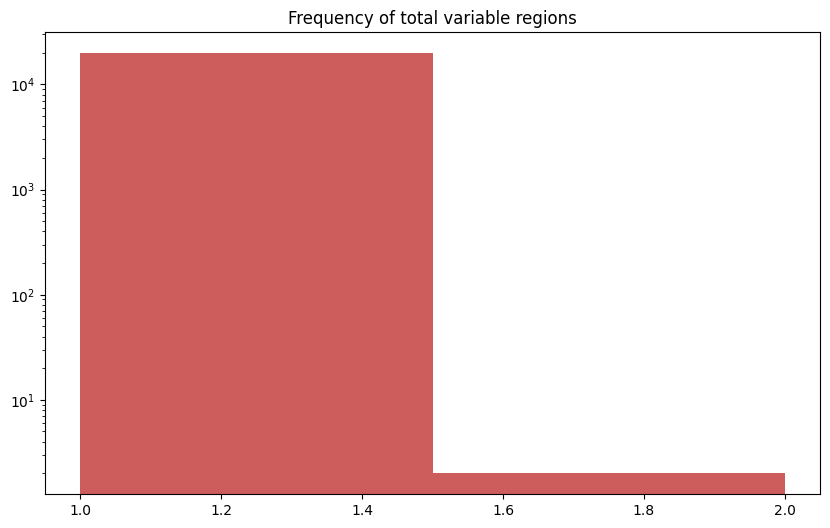

In [518]:
counts.plot(kind='hist', color='indianred', figsize=(10,6), bins = 2)
plt.yscale('log')
plt.ylabel(None)
plt.title('Frequency of total variable regions')
plt.show()

In [519]:
vdf[vdf['Sequence'].isin(['CCGCTTCACTCAGTAAGTAATGAGCG', 'CCTACTTCACTACCATCTATGGCAGC'])]

,ID,Sequence
915,954,CCGCTTCACTCAGTAAGTAATGAGCG
1735,1812,CCGCTTCACTCAGTAAGTAATGAGCG
4705,4943,CCTACTTCACTACCATCTATGGCAGC
8012,8417,CCTACTTCACTACCATCTATGGCAGC


#### Duplicate VRs
| Sequence IDs | Sequence | Frequency |
| --- | -------| ----|
| 954, 1812 | CCGCTTCACTCAGTAAGTAATGAGCG | 2 |
| 4943, 8417 | CCTACTTCACTACCATCTATGGCAGC | 2 |  

We find that total variable regions had two sequences with a duplicate. We mark these as important for further study.  For the rest of the dataset, we will pursue clustering techniques instead of alignment to find potential similarities.

#### d. Calculate observed/expected frequency of sequences to confirm enrichment

In [520]:
# Get copy numbers of the duplicated VRs
print(df[df['Sequence'].str.contains('CCGCTTCACTCAGTAAGTAATGAGCG')].drop('Sequence', axis=1))

print(df[df['Sequence'].str.contains('CCTACTTCACTACCATCTATGGCAGC')].drop('Sequence', axis=1))

      Copy Num  Length
954         23      98
1812        19      98
      Copy Num  Length
4943        13      98
8417        10      98


Seq 954,1812 had copy numbers 23 and 19 respectively.  
Seq 4943, 8417 had copy numbers 13 and 10 respectively.

In [521]:

print(len('CCGCTTCACTCAGTAAGTAATGAGCG'))
print(len('CCTACTTCACTACCATCTATGGCAGC'))

26
26


Both of the duplicates came from VR1 which has a length of 22.

In [522]:
# Assess background probability
p_vr1 = 1/4**22
print(f'{p_vr1:2e}')

# Calculate expected occurrences in 6e6 reads
expected = p_vr1 * 6e6
print(f'Expected Count of kmer: {expected:2e}')

5.684342e-14
Expected Count of kmer: 3.410605e-07


Expected count of the 22mer is << observed counts, which suggests the observed frequency is signficant. We need to look more closely at these newly found 26mer motifs because the sequences do not seem to have identical buffer regions. 

In [523]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

def align(seq1, seq2):
    alignments = pairwise2.align.localms(seq1, seq2, 2, -1, -2, -0.5)
    print(format_alignment(*alignments[0]))

In [524]:
df.iloc[954, 0]

'AGTGCCATCGTGCGTATCCGCTTCACTCAGTAAGTAATGAGCGAAGCAGACTGAGGCGTATGTCCACTCCATCACCCGGGTAGACTGGAGACACGACG'

In [525]:
SEQ954 = df.iloc[954, 0]
SEQ1812 = df.iloc[1812, 0]
SEQ4943 = df.iloc[4943, 0]
SEQ8417 = df.iloc[8417, 0]

for s in [SEQ954, SEQ1812, SEQ4943, SEQ8417]:
    for _ in [FP, MIP, RP]:
        align(s, _)
    print('-------------------------')

1 AGTGCCATCGTGCGTATCC
  |||||||||||||||||||
1 AGTGCCATCGTGCGTATCC
  Score=38

41 GCGAAGCAGACTGAGGC
   |||||||||||||||||
 1 GCGAAGCAGACTGAGGC
  Score=34

80 GTAGACTGGAGACACGACG
   |||||||||||||||||||
 1 GTAGACTGGAGACACGACG
  Score=38

-------------------------
1 AGTGCCATCGTGCGTATCC
  |||||||||||||||||||
1 AGTGCCATCGTGCGTATCC
  Score=38

41 GCGAAGCAGACTGAGGC
   |||||||||||||||||
 1 GCGAAGCAGACTGAGGC
  Score=34

80 GTAGACTGGAGACACGACG
   |||||||||||||||||||
 1 GTAGACTGGAGACACGACG
  Score=38

-------------------------
1 AGTGCCATCGTGCGTATCC
  |||||||||||||||||||
1 AGTGCCATCGTGCGTATCC
  Score=38

42 GCGAAGCAGACTGAGGC
   |||||||||||||||||
 1 GCGAAGCAGACTGAGGC
  Score=34

80 GTAGACTGGAGACACGACG
   |||||||||||||||||||
 1 GTAGACTGGAGACACGACG
  Score=38

-------------------------
1 AGTGCCATCGTGCGTATCC
  |||||||||||||||||||
1 AGTGCCATCGTGCGTATCC
  Score=38

42 GCGAAGCAGACTGAGGC
   |||||||||||||||||
 1 GCGAAGCAGACTGAGGC
  Score=34

80 GTAGACTGGAGACACGACG
   |||||||||||||||||||
 1 GTAGACTGGAGACACGAC

In [526]:
# 954 CC|GCTTCACTCAGTAAGTAATGAG|CG

In [527]:
print(f'{SEQ954[:v1_st]}|{SEQ954[v1_st:v1_end]}|{SEQ954[v1_end:v2_st]}|{SEQ954[v2_st:v2_end]}|{SEQ954[v2_end:]}') # found that I sliced up the buffer zones a bit wrong but nbd

AGTGCCATCGTGCGTAT|CCGCTTCACTCAGTAAGTAATGAGCG|AAGCAGACTGAGG|CGTATGTCCACTCCATCACCCGGGT|AGACTGGAGACACGACG


In [528]:
len(SEQ954[v1_end:v2_st])

13

#### e. Looking a bit closer at the duplicated whole VR motifs

In [529]:
align(SEQ954, SEQ1812)

AGTGCCATCGTGCGTATCCGCTTCACTCAGTAAGTAATGAGCGAAGCAGACTGAGGCGTATGTCCACTCCATCACCCGGGTAGACTGGAGACACGACG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||
AGTGCCATCGTGCGTATCCGCTTCACTCAGTAAGTAATGAGCGAAGCAGACTGAGGCGTATGTCCACTCCATCACCCTGGTAGACTGGAGACACGACG
  Score=193



In [530]:
align(SEQ4943, SEQ8417)

AGTGCCATCGTGCGTATCCTACTTCACTACCATCTATGGCAGCGAAGCAGACTGAGGCGTGTCATGTTTATACATAATCGTAGACTGGAGACACGACG
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||
AGTGCCATCGTGCGTATCCTACTTCACTACCATCTATGGCAGCGAAGCAGACTGAGGCGTGTCACGTTTATACATAATCGTAGACTGGAGACACGACG
  Score=193



Seq954 and 1812 are duplicates with a single mismatch in VR2, suggesting a sequence error. Same for SEQ4943 and SEQ8417.  Which means the total VR2 21mers are the same as well and should add to duplicate motif count.

In [531]:
align(SEQ954[v1_st:v1_end], SEQ4943[v1_st:v1_end])

align(SEQ954[v2_st:v2_end], SEQ4943[v2_st:v2_end])

1 CCG-CTTCACTCAGTAAGTAATG--AGC
  ||. ||||||| |..|..| |||  |||
1 CCTACTTCACT-ACCATCT-ATGGCAGC
  Score=22.5

1 CGT---ATGTCCACTCCATCACCCGGGT
  |||   ||||..| |.|||.|.|   ||
2 CGTGTCATGTTTA-TACATAATC---GT
  Score=19



No alignment between VRs, so they are distinct.

### 3. Sub-total variable regions analysis: 
#### kmer extraction from buffered variable regions

In [532]:
def extract_kmers(seq, k):
    """Extracts kmers from a sequence. Saves position and kmer chunk to preserve order and distance information for downstream secondary structure analysis. Collects kmers from all k reading frames."""
    all_kmers = [(i, seq[i:i+k]) for i in range(len(seq)-k+1)]
    return all_kmers

In [533]:
def getkmers(df, k, start=0, stop=len(df)):
    """Performs row-level extraction of kmers and returns long-form df. Default column is full sequence, specify variable region. Specify start position offset for variable region, or default is to 0."""
    kmer_data = []
    for idx, row in df.iterrows():
        kmers = extract_kmers(row['Sequence'][start:stop], k)
        for position, kmer in kmers:
            kmer_data.append({'Sequence_ID': idx, 'Position': position + start, 'k-mer': kmer})
    
    kmer_df = pd.DataFrame(kmer_data)
    return kmer_df

In [534]:
# Recall: vdf is combined VRs of length 98 sequences
df10 = getkmers(df=vdf, k=10)
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326469 entries, 0 to 326468
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Sequence_ID  326469 non-null  int64 
 1   Position     326469 non-null  int64 
 2   k-mer        326469 non-null  object
dtypes: int64(2), object(1)
memory usage: 7.5+ MB


### a. k=10 Frequency distribution

In [538]:
count_10 = df10['k-mer'].value_counts()
count_10

k-mer
CCGCTTCACT    178
CGCGCCCCCA    155
CCTACTTCAC    140
CCGCTTCACG     92
CCGCTTCACC     92
             ... 
TTTCGGTCCA      1
TCGGTCCACG      1
CGGTCCACGC      1
TCTTGCTTCC      1
CGCTACTCCT      1
Name: count, Length: 230893, dtype: int64

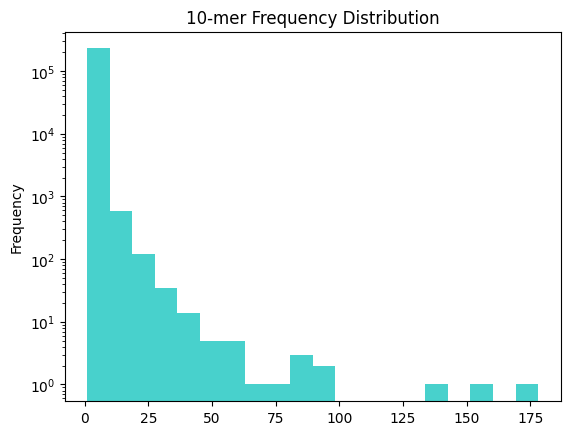

In [542]:
# Plot histogram to get overview of distribution
k=10
count_10.plot(kind='hist', color='mediumturquoise', bins=20)
plt.yscale('log')
plt.figsize=(10,6)
plt.title(f'{k}-mer Frequency Distribution')
plt.show()

There are only a handful of 10mers which have more than 100 occurrences, and more than 10,000 of the 10mers only have 1 occurrence.  But the kmers which occur with high frequency may be candidates for convergence motifs. 

Rarely occurring kmers are not necessarily indicative of no function because our pool average function was so high. I wonder if the large number of rare kmers may indicate that they are not random - we previously theorized functional diversity.  

We observe that compared to 22 and 21nt TVRs where there were literally only 2 sequences with duplicates, distribution is pulling to the right.  This may be because the functional motif is smaller than the TVR length and may appear more populous when measured this way.  Slicing into kmers may also make the alignment more robust to sequencing errors and single point mutations as there is less dependence on a complete match to register as a duplicate motif.

However, a smaller kmer may also occur more frequently.